#  Quantum Mentorship Program
## Task-2(Solution) 

In [10]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt
from qiskit.aqua.components.optimizers import COBYLA, SLSQP, SPSA
import torch

In [11]:
backend=BasicAer.get_backend('statevector_simulator')

# Preparation of Required state
### The state $\frac{\left| 01 \right\rangle + \left| 10 \right\rangle}{\sqrt{2}}$, is prepared and the statevector for the state is obtained 

In [12]:
qr=QuantumRegister(2)              #The required state is prepared to produce the desired statevector
qc=QuantumCircuit(qr)
qc.h(qr[0])
qc.x(qr[1])
qc.cx(qr[0], qr[1])
result=execute(qc, backend).result()
psi=result.get_statevector(qc)

# The Solution using parameterized gates
### Circuit using parameterized gates $R_{x}(\theta)$ and $R_{y}(\theta)$ is used to get the desired result .
#### The parameters of the gates are obtained by using SLSQP optimizer to optimize the value generated after each iterations

In [13]:
def var_forms(params):      #Function to create the variational form for each iteration using
    qr1=QuantumRegister(2)   # parametric gates
    qc1=QuantumCircuit(qr1)
    qc1.ry(params[0], qr1[0])  
    qc1.ry(params[1], qr1[1])
    qc1.cx(qr1[0], qr1[1])
    return qc1

In [14]:
def objective_functions(params):  #This is the cost or objective cost function to calculate the cost
    circuit= var_forms(params)         # obtained by the current parameter. The optimizer varying the parameters to minimize the cost 
    result=execute(circuit, backend).result()    
    counts=result.get_statevector(circuit)
    cost= sum([np.abs(counts[i]-psi[i]) for i in range(4)])
    return cost
    

In [15]:
optimizer= SLSQP(maxiter=20)    #The optimizer is used to optimize the variational parameters
params= np.random.randn(2)
output= optimizer.optimize(num_vars=2, objective_function= objective_functions, initial_point= params)

# Ouput using the parameters obtained

In [16]:
# Here we check the output and compare it to the actual state
qc = var_forms(output[0])   
counts = execute(qc, backend).result().get_statevector(qc)

print("Target state :", psi.real)
print("Obtained state :", counts.real)
print("Output Error (Manhattan Distance) :", output[1])
print("Parameters Found: ", output[0])

Target state : [0.         0.70710678 0.70710678 0.        ]
Obtained state : [3.36089939e-09 7.07093877e-01 7.07119685e-01 3.36077673e-09]
Output Error (Manhattan Distance) : 2.581433473160566e-05
Parameters Found:  [1.57075983 3.14159264]


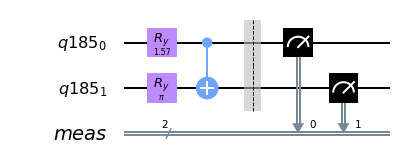

In [17]:
qr2=QuantumRegister(2)
cr2=ClassicalRegister(2)
circuit_final=QuantumCircuit(qr2, cr2)
circuit_final=var_forms(output[0])
circuit_final.measure_all(qr2)
circuit_final.draw(output='mpl')


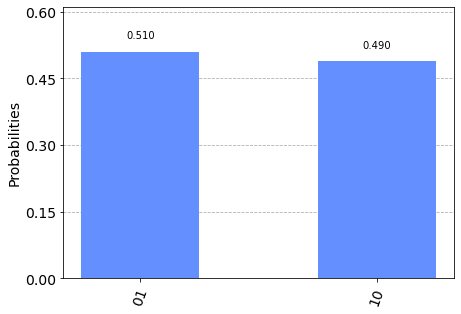

In [18]:
#This is the histogram plot for the result obtained once the circuit is run on qasm simulator
backend2=BasicAer.get_backend('qasm_simulator')
result1=execute(circuit_final, backend2, shots=1000).result().get_counts(circuit_final)
plot_histogram(result1)

In [19]:
#Here we see the effects of NUM_OF_SHOTS on the circuit and we decipher how far the 
#obtained parameters from the required values
def get_probability_distribution(counts, i):
    output_distr = [v / i for v in counts.values()]
    if len(output_distr) == 1:
        output_distr.append(0)
    return output_distr
NUM_SHOTS=[1,10,100,1000, 10000]
value1=[]
value2=[]
cost1=[]
for i in NUM_SHOTS:    
    result2=execute(circuit_final, backend2, shots=i).result().get_counts(circuit_final)
    desired_dict={'01':i/2, '10':i/2}
    desired=get_probability_distribution(desired_dict, i)
    out=get_probability_distribution(result2, i)
    loss = sum([np.abs(out[i] - desired[i]) for i in range(2)])
    cost1.append(loss)
    


Text(0, 0.5, 'Cost')

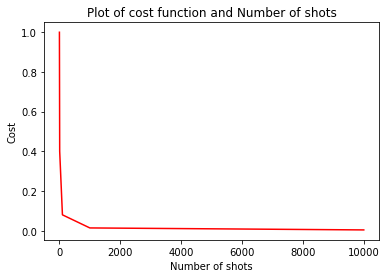

In [20]:
plt.plot(NUM_SHOTS, cost1, color='red')
plt.title("Plot of cost function and Number of shots")
plt.xlabel("Number of shots")
plt.ylabel("Cost")